## Load Libraries and import modules 

In [1]:
# Load all the vanila libraries 
import numpy as np
import pandas as pd
import numpy.random as nrd
import os
import re
import pathlib 
import sys
from typing import Callable


#
import umap

# Pytorch modules 
import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim

# this for the custom Dataset 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
import plotly.graph_objects as go



# Import tqdm for progress bar
from tqdm.auto import tqdm

# for timing functions
from timeit import default_timer as timer 

### Configure Project Parameters

In [2]:
# check your current directory
os.getcwd()

'c:\\Users\\gpano\\Desktop\\github_py\\proteomics_latent_space'

**Important:** Run the configuration file first `configs.py`. Importing this script and setting the seed and device parameters before importing any of the other modules ensures that evereything is sync.

**Important** If you want *change the configuration parameters*, change them before importing and running the pipeline. 

In [3]:
from models_util import configs

Importing models_util.configs module
First set device and seed for reproducibility.
-----------------------------------------------


In [4]:
configs.get_configs()

'Seed: None, Device: None'

In [5]:
# print the global variables
print(configs.project_seed, configs.project_device)

None None


In [6]:
configs.set_seed(888)
device = configs.set_device(force_cpu=True)

# global variables have changed too
print(configs.project_seed, configs.project_device)

During configuration random seed 888 has been set.
888 cpu


In [7]:
# lets see if the get function also agrees:
configs.get_configs()

'Seed: 888, Device: cpu'

Now that all the configurations values are assigned globally, we can import the modules. If this is working, we expect each module to access the **same** **seed** and **device** we set. We are also expecting generated numbers **inside the modules** to be reproducible.

In [8]:
# Load home modules and check the device where they are running 
from models_util import utility_functions as uf

During configuration random seed 888 has been set.
Importing models_util.utility_functions, running in cpu with seed: 888


In [9]:
from models_util import custom_dataset as cd

During configuration random seed 888 has been set.
Importing models_util.custom_dataset, running in cpu with seed: 888


In [10]:
from models_util import cost_functions as cf

During configuration random seed 888 has been set.
Importing models_util.cost_functions, running in cpu with seed: 888


In [11]:
from models_util import VAE1 as v1 


During configuration random seed 888 has been set.
Importing models_util.VAE1, running in cpu with seed: 888


In [12]:
from models_util import VAE2 as v2 


During configuration random seed 888 has been set.
Importing models_util.VAE2, running in cpu with seed: 888


## SCBC Data scale and split for VAE
- We will perform min-max scaling to the TMT-Ratios of the proteomic SCBC data. <br>
- We will scale the array version of our scbc data, the `npscbc` matrix.
- Then we will copy this scaled matrix and reshuffle the copy. The `npscbc_scaled_shuffled` will be used for the model training and performance evaluattion. <br>
- The `npscbc_scaled` matrix with the original order of rows will be used later for the validation of the latent variables. <br> 
- It is important to use the non-missing min and max values of dataset row-by-row <br>

In [13]:
# create path and read the scbc data
data_path = os.getcwd() + "\\data\\processed\\" 
scbc = pd.read_csv(data_path+"protein_quant_merged.txt",delimiter="\t")
scbc

,FS1.A.A431,FS1.B.A431,FS2.A.A431,FS2.B.A431,FP1.A.A431,FP1.B.A431,FP2.A.A431,FP2.B.A431,FP3.A.A431,FP3.B.A431,...,FS1.A.U2OS,FS1.B.U2OS,FS2.A.U2OS,FS2.B.U2OS,FP1.A.U2OS,FP1.B.U2OS,FP2.A.U2OS,FP2.B.U2OS,FP3.A.U2OS,FP3.B.U2OS
A2M,0.852119,0.565302,0.036629,-0.039377,-0.057012,-0.140135,0.473900,0.258704,0.186024,0.158778,...,0.577856,0.656379,0.752162,0.781217,-0.496002,-0.361617,-0.218204,-0.162061,0.008398,-0.000756
A4GALT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAAS,-1.131918,-1.194426,-1.227171,-1.547809,0.992723,1.003424,0.496371,0.509193,0.496316,0.539934,...,-0.353878,-0.445141,-0.921733,-0.767294,1.062990,1.077347,0.572733,0.522856,0.199937,0.309743
AACS,1.814433,1.869513,0.260283,0.069822,-0.850519,-0.832544,-1.043813,-1.171955,-1.214689,-1.322565,...,2.582234,2.558867,0.018478,0.052961,-0.464070,-0.446440,-0.742088,-0.716008,-0.849702,-0.724803
AADAT,0.430359,0.176434,0.739991,0.523358,-0.031550,-0.002690,0.439815,0.278928,-0.889609,-0.924090,...,-0.876662,-0.861607,1.464253,1.794939,-0.185816,-0.118292,0.406696,0.506368,-0.302882,-0.385006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001729,0.572817,1.337533,1.426455,-0.490661,-0.772817,0.348187,-0.931258,-0.003848,-0.315998
ZYG11B,1.098904,1.077441,0.772081,0.275709,0.072157,-0.048372,-0.815593,-0.797889,-0.701914,-0.303999,...,1.428985,1.401043,0.782410,0.834629,-0.576645,-0.397502,-0.428291,-0.263277,-0.697264,-0.623714
ZYX,1.569980,1.610707,0.306789,0.336856,-0.512978,-0.543941,-0.608183,-0.620853,-0.820432,-0.772130,...,1.885349,1.919763,0.152767,-0.082805,-0.372399,-0.443941,-0.453746,-0.549032,-0.515579,-0.462772
ZZEF1,1.267430,1.238671,-0.283524,-0.293160,-0.400721,-0.473204,-0.531321,-0.594985,0.406842,0.369355,...,1.973243,1.958321,-0.274510,-0.316475,-0.468573,-0.425547,-0.469236,-0.425863,-0.297432,-0.180919


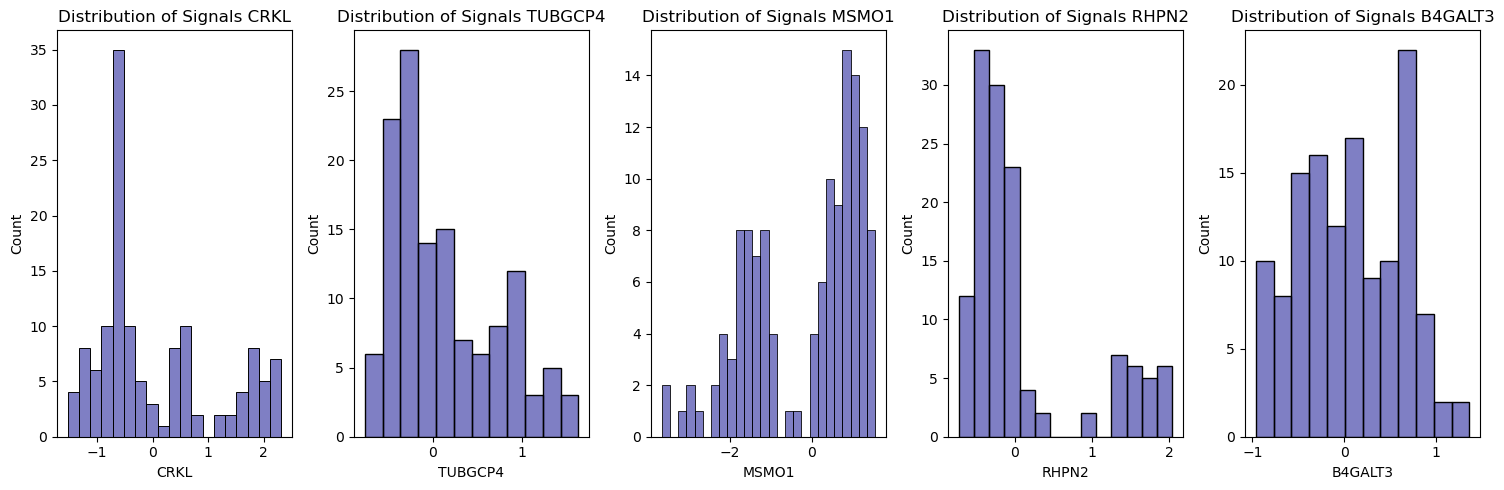

In [14]:
fig, ax = plt.subplots(1,5,figsize=(15,5))
rand_idx = nrd.randint(0,scbc.shape[0],5)

for i,idx in enumerate(rand_idx):
    sns.histplot(scbc.iloc[idx,:], binwidth=.2,ax=ax[i], color="darkblue", alpha=.5)
    ax[i].set_title("Distribution of Signals " + str(scbc.index[idx]))
    plt.tight_layout()
plt.show()

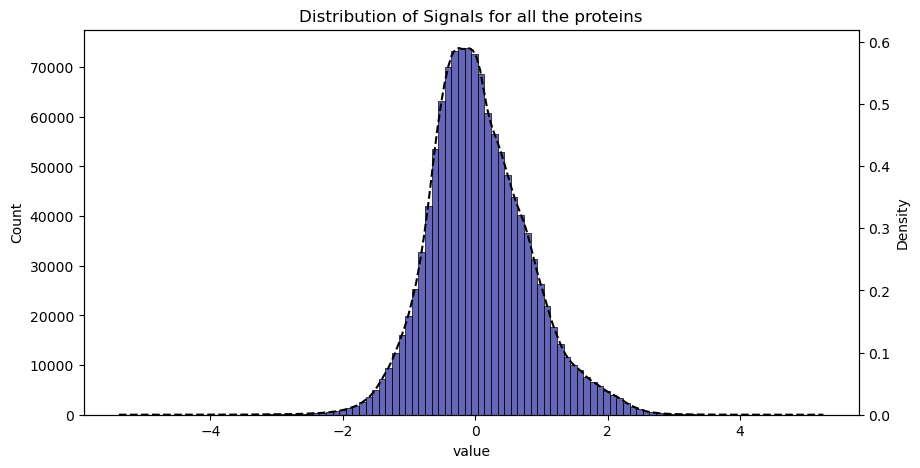

In [15]:
# distribution of all the proteome signals - keep the protein names for outlier analysis 
fig, ax = plt.subplots(1,1,figsize=(10,5))
scbc.melt().pipe((sns.histplot, "data"), x="value", binwidth=.1, ax=ax, color="darkblue", alpha=.6)
ax2 = ax.twinx()
sns.kdeplot(scbc.melt(),x = "value", ax=ax2, color="black", ls = "--")
# ax.set_xlim(-4,5)
ax.set_title("Distribution of Signals for all the proteins")
plt.show()

In [16]:
# convert to numpy 
npscbc = scbc.to_numpy()
np.isnan(npscbc).sum()


np.int64(104200)

In [17]:
# Get extreme values (non-missing) frome ach row. 
scbc_min = np.nanmin(npscbc, axis=1, keepdims=True)  # minimum among non-NaN
scbc_max = np.nanmax(npscbc, axis=1,keepdims=True)  # maximum among non-NaN

# check that that shapes and values are as expected 
print(scbc_max.shape,scbc_min.shape,np.isnan(scbc_max).sum(), np.isnan(scbc_min).sum())

(10439, 1) (10439, 1) 0 0


In [18]:
# scale data 
npscbc_scaled = (npscbc - scbc_min) /(scbc_max - scbc_min + 1e-8)
npscbc_scaled.shape

# npscbc_scaled[0:2,]

(10439, 130)

In [19]:
# shuffle the rows but keep scaled original
npscbc_scaled_shuffled = npscbc_scaled.copy()
np.random.shuffle(npscbc_scaled_shuffled)
# npscbc_scaled[1,],scbc.iloc[1,:12]


### Split Data 

In [20]:
train_data, val_data, test_data = uf.create_data_partition(
    npscbc_scaled_shuffled, test_perc=0.15, val=True, val_perc=0.1
)
train_data.shape, val_data.shape, test_data.shape

((7829, 130), (1044, 130), (1566, 130))

You can test reproducibility by re-runing the function and checking the data in the first index of the matrix. We expect it to be the same. 

### Pass data to Custom Dataset and DataLoaders 
- check that your data is numpy matrix.
- check if data is scaled to (0,1).
- create three custom dataset instances.
- the custom dataset will save all the data to memory and create a mask where NaNs are located.
- the numpy arrays will be converted to tensors of appropriate dimensions and NaNs to zeroes.
- then we pass the custom dataset to the dataloader object.
- The DataLoader object contains for each row (training example) i) a tensor of 1 x 130 columns with 0-1 scaled values, ii) a 1x130 mask indicating NA positions and iii) index of the examples per batch (could be 64, 128,..., batch_size). 

In [21]:
train_dataset = cd.ProteinDataset(train_data)
val_dataset = cd.ProteinDataset(val_data)
test_dataset = cd.ProteinDataset(test_data)

Protein Dataset is passed to memory
No Protein Symbols were identified
Protein Dataset is passed to memory
No Protein Symbols were identified
Protein Dataset is passed to memory
No Protein Symbols were identified


In [22]:
# pass data to the dataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,drop_last=True)

In [23]:
# the train loader is not reproducible bcs it shuffles but it is not seeded yet. 
# here is one batch of training examples 
# torch.manual_seed(888)


next(iter(train_loader))

[tensor([[0.8343, 0.8104, 0.3531,  ..., 0.2316, 0.2102, 0.2183],
         [0.2484, 0.2599, 0.6080,  ..., 0.1457, 0.3316, 0.4025],
         [0.7708, 0.7893, 0.5258,  ..., 0.2597, 0.2167, 0.2229],
         ...,
         [0.0931, 0.0515, 0.4589,  ..., 0.4239, 0.4196, 0.3828],
         [0.1517, 0.2030, 0.4534,  ..., 0.5712, 0.2304, 0.2499],
         [0.1284, 0.1594, 0.1167,  ..., 0.8184, 0.8197, 0.8392]]),
 tensor([[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]),
 tensor([1303, 3377, 4092, 3661, 5200, 4902, 1677, 4550, 7674, 3034, 4700, 6041,
         1500, 4152, 5520, 5702, 3151, 7283, 7522, 4357, 6228, 3072, 4592, 2929,
         3692, 2954, 2852, 5003, 2328, 1494, 4280, 5245, 4233,

## Training-Validation Loop 
It comprises the run of the training and validation set. VAE inherently have a tendency to overfit, so it is important to keep the test set after training loop. In this tutorial we run one model. The name is based on a simple numbering system and its layers to track it down. Furthermore the train_val_loop creates a hyperparameter string to track other parameters. The whole loop is parametrized in a function: <br>
- The function starts with a pre-training evaluation to initialize metrics at epoch = 0 <br>
- Then training of the model begins and after each epoch, the validation set is passed through the model to get the validation - epoch metrics.<br>


During training, these are computed:
- KL, Gaussian Logliklihood error, and Total Error are monitored per training batch, and also averaged every n batches.
- KL, Gaussian Logliklihood error, and Total Error are monitored per validation round (per epoch).

In [24]:
hidden_dim = 90
latent_dim = 45
n="2_early_newfunc" 

# Instantiate the model
model1 = v1.VAE(
    n_features=130,
    latent_dim=latent_dim,
    hidden_layer=True,
    hidden_dim=hidden_dim,
    output_activ = nn.Sigmoid()
).to(device)

model2 = v2.VAE(n_features=130,
              latent_dim=45,
              hidden_layer= True,
              hidden_dim_1=100,
              hidden_dim_2=75,
              sigmoid=True).to(device)


# need to set the model name with the layers - usefull for creating its unique folder 
model_name = f"model_{n}_{hidden_dim}_{latent_dim}"

# the optimizer is in the train-val loop 


## Create a "models" folder and the specifics model's directory to save figures  

# create the models directory path 
path_dir = os.getcwd() + "\\models"

# Check if the models directory exists, if not, create it
if not os.path.exists(path_dir):
    os.makedirs(path_dir)
    print(f"Created directory: {path_dir}")
else:
    print(f"Directory already exists: {path_dir}")

# create a subdirectory for each model based on #number and name (the dims of layers)
model_path = os.path.join(path_dir,model_name)
if not os.path.exists(model_path):
    os.makedirs(model_path)
model_path


## Final Important part

# set all the parameters to variables because all functions depend on them
model = model1
loss_fun = cf.loss_fun
model_name=model_name
path=model_path
epoch = 200
learn_r = 0.005
freebits = 2
patience = 7
batch_size = 128
norm = 0

# the path where this model is going to be saved 
path

Directory already exists: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models


'c:\\Users\\gpano\\Desktop\\github_py\\proteomics_latent_space\\models\\model_2_early_newfunc_90_45'

In [25]:
# He initialization - no difference 
# model.init_weights()

In [26]:
# x = next(iter(model1.modules()))
# x.encoder[0].weight

In [27]:
# Run the loop - see the parameters 
# extract the batch, epoch data and the parameters string

batch_dict, epoch_dict,hyperparam_str = uf.train_val_loop_v2(
model = model,
train_loader=train_loader,
val_loader=val_loader, 
loss_fun = loss_fun,
model_name=model_name,
model_path=path,
epoch = epoch,
patience=patience,
learn_r = learn_r,
freebits = freebits,
batch_size = batch_size,
norm = norm
)

  0%|          | 0/201 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 63.334| Val KL: 62.38324737548828 | Val Rec: 0.951

Epoch 1
--------------------
Train loss: 62.234|Train Rec: -0.165 | Val loss: 61.847, Val Rec: -0.537

Epoch 2
--------------------
Train loss: 61.830|Train Rec: -0.573 | Val loss: 61.788, Val Rec: -0.598

Epoch 3
--------------------
Train loss: 61.776|Train Rec: -0.628 | Val loss: 61.729, Val Rec: -0.655

Epoch 4
--------------------
Train loss: 61.685|Train Rec: -0.714 | Val loss: 61.735, Val Rec: -0.648

Epoch 5
--------------------
Train loss: 61.650|Train Rec: -0.748 | Val loss: 61.660, Val Rec: -0.724

Epoch 6
--------------------
Train loss: 61.631|Train Rec: -0.766 | Val loss: 61.678, Val Rec: -0.705

Epoch 7
--------------------
Train loss: 61.614|Train Rec: -0.782 | Val loss: 61.579, Val Rec: -0.805

Epoch 8
--------------------
Train loss: 61.605|Train Rec: -0.790 | Val loss: 61.641, Val Rec: -0.742

Epoch 9
--------------------
Train loss: 61.583|Train 

In [28]:
# Finally create a model id which is comprised by the model_name and training hyperparameters
model_id = model_name + "_" + hyperparam_str
model_id

'model_2_early_newfunc_90_45_ep94_norm0_bits2_bs128_lr0.001'

## Train-Val Diagnostics 

In [29]:
#The path for all the figures related to the models performance 
path = model_path
path

m = re.search("ep(\d+)",hyperparam_str, re.IGNORECASE)
epoch_run = int(m.group(1)) + 10
epoch_run

<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
C:\Users\gpano\AppData\Local\Temp\ipykernel_23476\3701144515.py:5: SyntaxWarning: invalid escape sequence '\d'
  m = re.search("ep(\d+)",hyperparam_str, re.IGNORECASE)


104

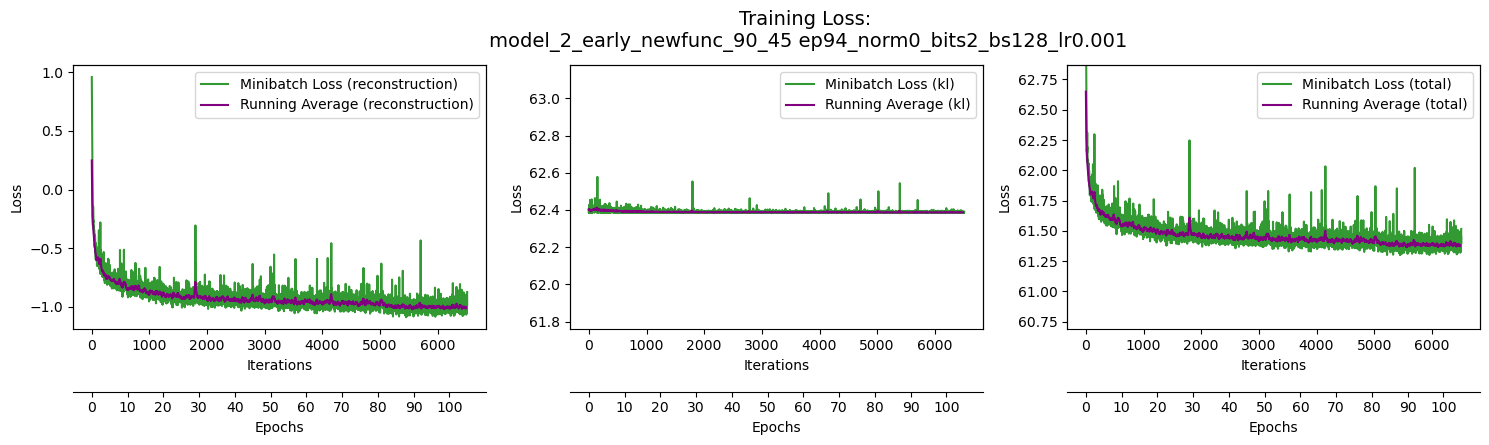

In [30]:
fig, axes = plt.subplots(1,3,figsize=(15,4))

# use the plot trainining_loss_sp function for all the error in the iteration dictionary 
uf.plot_training_loss_sp(axes[0], batch_dict["Train Rec Loss"], epoch_run, averaging_iterations=20, custom_label=" (reconstruction)")
uf.plot_training_loss_sp(axes[1], batch_dict["Train KL Loss"], epoch_run, averaging_iterations=20, custom_label=" (kl)")
uf.plot_training_loss_sp(axes[2], batch_dict["Train total Loss"], epoch_run, averaging_iterations=20, custom_label=" (total)")

fig.suptitle(f"Training Loss:\n {model_name} {hyperparam_str}",
             y=1.1,x=.54,
             fontsize=14)
plt.subplots_adjust(hspace=0.35)  # Adjust the value as needed

plt.savefig(path + "\\trainloss_curve.png", dpi=600, bbox_inches="tight")
plt.show()

In [31]:
epoch_df = uf.convert_epoch_df(epoch_dict)

   epoch  Train total Loss  Train KL Loss  Train Rec Loss  Val total Loss  \
0      0         63.334460      62.383247        0.951213        63.33446   
1      1         62.233897      62.399237       -0.165340        61.84672   

   Val KL Loss  Val Rec Loss  rec_dif    kl_dif  total_dif  
0    62.383247      0.951213  0.00000  0.000000   0.000000  
1    62.383789     -0.537070  0.37173  0.015448   0.387177  


In [32]:
model_path

'c:\\Users\\gpano\\Desktop\\github_py\\proteomics_latent_space\\models\\model_2_early_newfunc_90_45'

df inserted


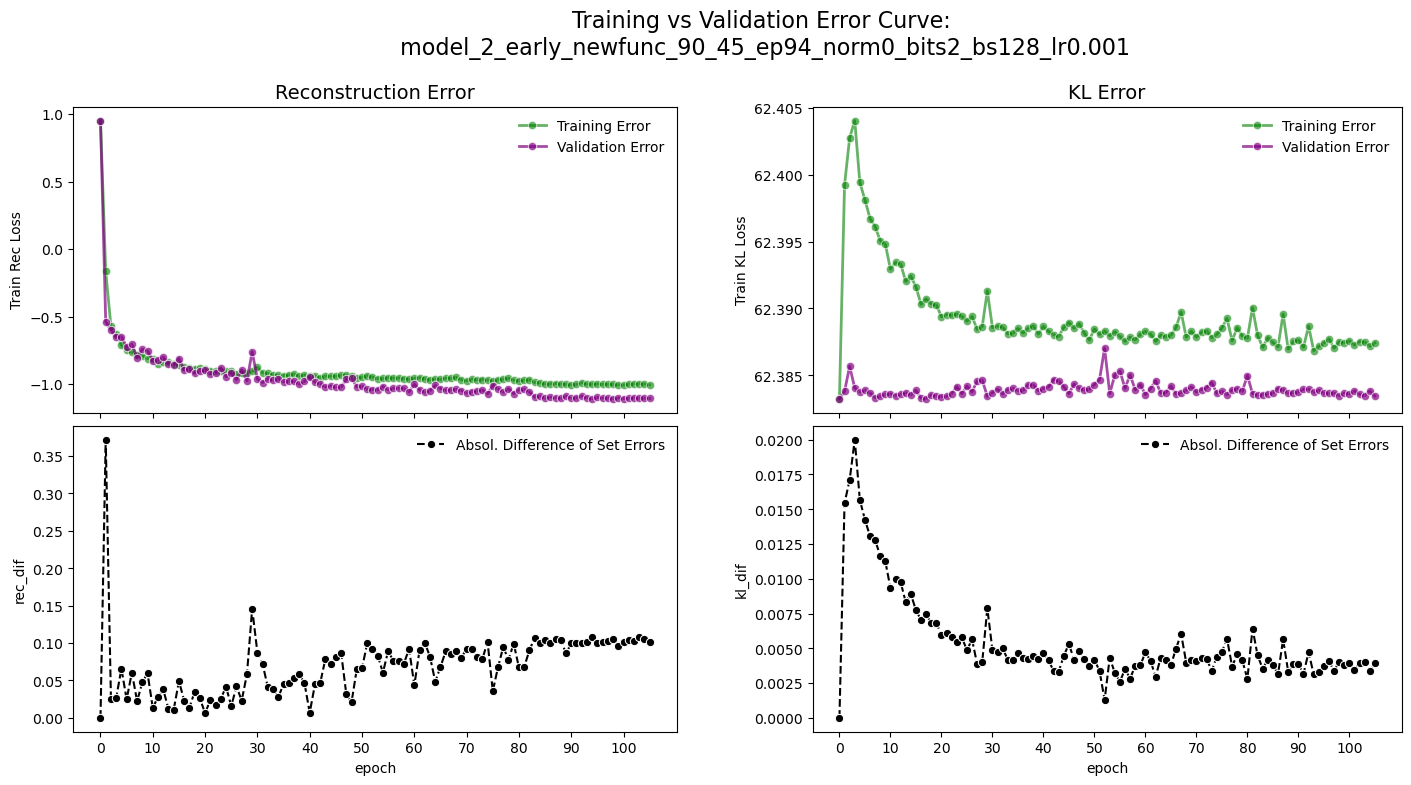

In [33]:
uf.get_train_vs_val_metrics(
    epoch_df=epoch_df,
    savepath=model_path,
    epoch=epoch_run,
    model_id=model_id
)

## Test Set Analysis 
VAE inherently have a tendency to overfit, even their validation set, so it is important to keep an independent test set after training loop. <br>
During training the model has been evaluated by the val set. However, here we will run the test set to examine **how well it generalizes**.<br> 
Furthermore we will perform **diagnostic tests** for the model's exploratory **latent variables**. <br>


Sometimes the decoder works better than anticipated and it's Reconstruction error is higly **optimistic**. Also, it is quite usual<br>
in the literature that low reconstruction errors might be followed by **distortions in the latent space**. It happens when we try to **over-regularlize** <br>
the KL-error to avoid the **latent collapse** phenomenon. 

There is a **tradeoff** between good reconstructions, and higly informative latent variables.

From the test set we will include **8 criteria**:
- we extract the per batch/losses
- average losses of the whole set 
- kl/dimension from the whole test set. (how information is stored in each dimension?)
- correlation of the different dimensions (are they overlapping in terms of information?)
- measure the active units/dimensions (are the variances above a threshold or have they collapsed?)
- we will perform a transversal test (is the latent space continuous?)
- investigate actual reconstructions of protein matrices
- perform UMAP and visualize in 3D/2D. We have prior knowledge of this dataset and we expect the formation of clusters.

In [34]:
test_iter_dict, test_metrics = uf.test_set_analysis(
    model=model,
    test_loader=test_loader,
    loss_fun = loss_fun,
    freebits=freebits,
    model_id=model_id
)

Using this model model_2_early_newfunc_90_45_ep94_norm0_bits2_bs128_lr0.001


#### Outputs 
- The putputs of the test set analysis are **two dictionaries**: `test_set_dict` and `test_metrics` 
- The first contains the following keys:
   - `dict_keys(['iteration', 'Test total Loss', 'Test KL Loss', 'Test Rec Loss', 'Test batch index', 'x_orig tensors', 'x_mu tensors', 'masks'])` <br>
   - The first four are floats, the per iteration metrics 
   - The last four are tensors detached from the computation graph
- The `test_metrics` contains the followin keys:
    - `dict_keys(['model_id', 'bits', 'avg_total_loss', 'avg_kl_loss', 'avg_rl_loss'])`
    - vanila python objects 

In [35]:
test_metrics.keys()

dict_keys(['model_id', 'bits', 'avg_total_loss', 'avg_kl_loss', 'avg_rl_loss'])

In [36]:
test_iter_dict.keys()

dict_keys(['iteration', 'Test total Loss', 'Test KL Loss', 'Test Rec Loss', 'Test batch index', 'x_orig tensors', 'x_mu tensors', 'masks'])

In [37]:
pd.DataFrame([test_metrics])

,model_id,bits,avg_total_loss,avg_kl_loss,avg_rl_loss
0,model_2_early_newfunc_90_45_ep94_norm0_bits2_b...,2,61.277071,62.383758,-1.106687


In [38]:
pd.concat([pd.DataFrame([test_metrics]),pd.DataFrame([test_metrics])],axis=0)

,model_id,bits,avg_total_loss,avg_kl_loss,avg_rl_loss
0,model_2_early_newfunc_90_45_ep94_norm0_bits2_b...,2,61.277071,62.383758,-1.106687
0,model_2_early_newfunc_90_45_ep94_norm0_bits2_b...,2,61.277071,62.383758,-1.106687


### Loss Curves

Using this model model_2_early_newfunc_90_45_ep94_norm0_bits2_bs128_lr0.001


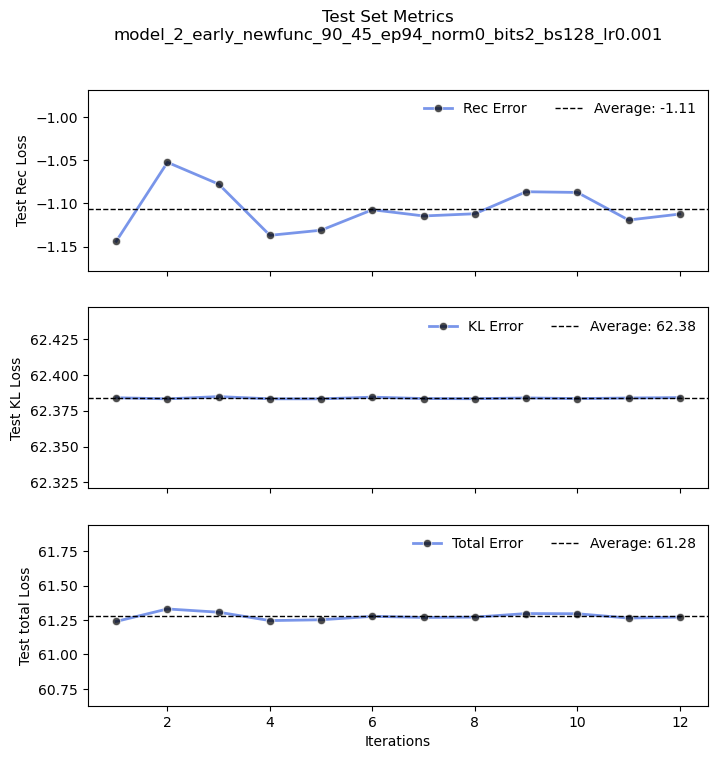

In [39]:
uf.plot_test_losscurves(
    test_iter_dict=test_iter_dict,
    test_metrics=test_metrics,
    model_id=model_id,
    model_path=model_path
)

### Matrix Recosntructions

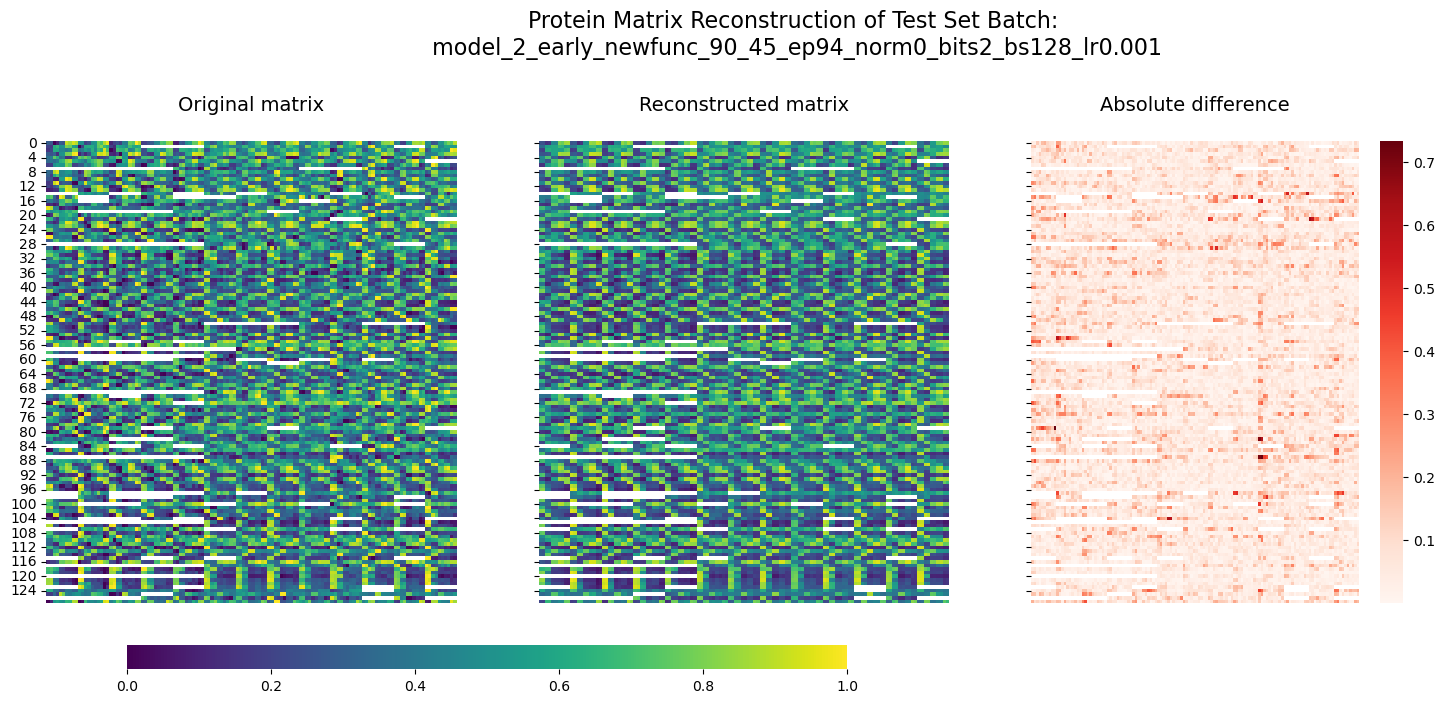

In [40]:
uf.get_matrix_rec(
    test_iter_dict=test_iter_dict,
    model_id=model_id,
    model_path=model_path
)

### Saturation and Redundanncy Tests


In [41]:
# get latent variables 

model = model
data_loader = test_loader
freebits = freebits

# Nested dictionary
kl_dict = {}
kl_dict['batch_kls'] = {}
kl_dict['batch_stds'] = {}
kl_dict['avg_kl_per_dim'] = None
kl_dict['std_kl_per_dim'] = None
kl_dict["freebits"] = freebits 

# initiate values 
kl_sums = 0
kl_sums_sq = 0
count = 0 

model.eval()
with torch.inference_mode():
    for idx,(xb, ms, _) in enumerate(data_loader):
        xb, ms, = xb.to(device), ms.to(device)

        x_mu, x_logvar, z_mu, z_logvar = model(xb)

        # compute KL dimension wise 
        kl_term = 0.5 * (torch.exp(z_logvar) + z_mu**2 - 1.0 - z_logvar)
        
        kl_sum_batch = kl_term.sum(dim=0)
        avg_kl = kl_sum_batch/kl_term.shape[0]
        std_kl = kl_term.std(dim=0)

        # save batch results
        kl_dict["batch_kls"][idx+1] = avg_kl.cpu().numpy()
        kl_dict["batch_stds"][idx+1] = std_kl.cpu().numpy()

        kl_sums += kl_sum_batch
        kl_sums_sq += kl_term.pow(2).sum(dim=0)
        count += kl_term.shape[0]
    
    avg_kl_perdim = kl_sums / float(count) 
    
    # E[KL^2]
    mean_kl_sq = kl_sums_sq / float(count)   
    
    # variance
    var_kl = mean_kl_sq - avg_kl_perdim**2
    var_kl = torch.clamp(var_kl, min=0.0)
    std_kl_per_dim = torch.sqrt(var_kl)
    
    kl_dict['avg_kl_per_dim'] = avg_kl_perdim.cpu().numpy()
    kl_dict['std_kl_per_dim'] = std_kl_per_dim.cpu().numpy()




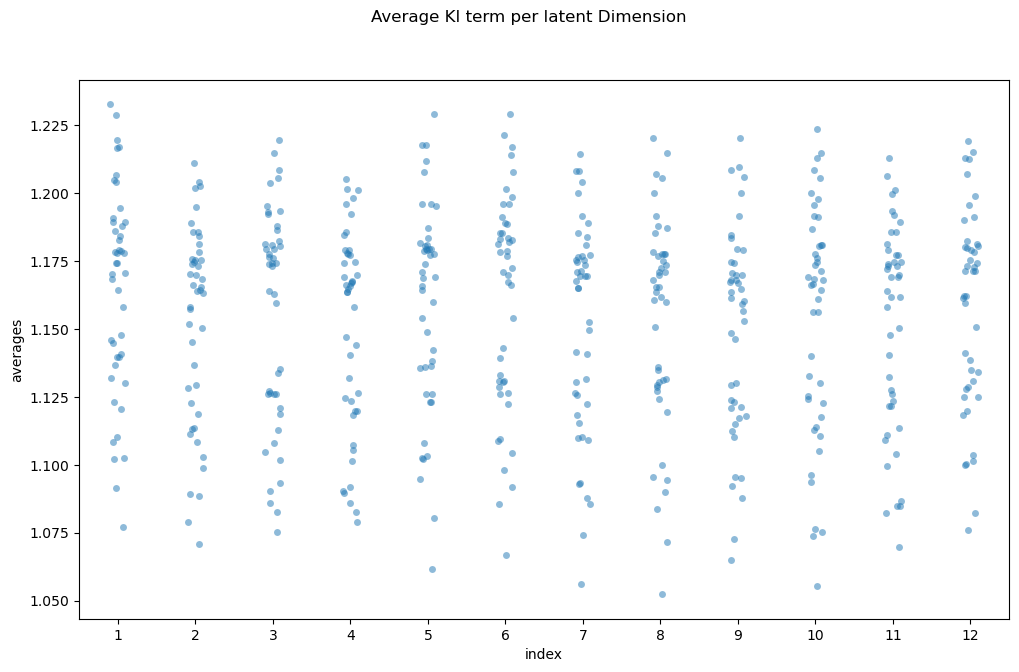

In [42]:
klperdim_df = pd.DataFrame(kl_dict["batch_kls"])
klperdim_df.index = [f"dim{i}" for i in range(1,klperdim_df.shape[0]+1)]
klperdim_df.T
klperdim_df = pd.melt(klperdim_df.T, ignore_index=False,var_name="dimensions",value_name="averages")
klperdim_df.reset_index(inplace=True)

plt.figure(figsize=(12,7))
sns.stripplot(
    data=klperdim_df, x="index", y="averages",
    dodge=True, alpha=.5, legend=False,
)
plt.suptitle("Average Kl term per latent Dimension")
plt.show()

In [43]:
def normalize(x, old_min=-1, old_max=1, new_min=0, new_max=1):
    return (x - old_min) / (old_max - old_min) * (new_max - new_min) + new_min

normalize(0.5)

0.75

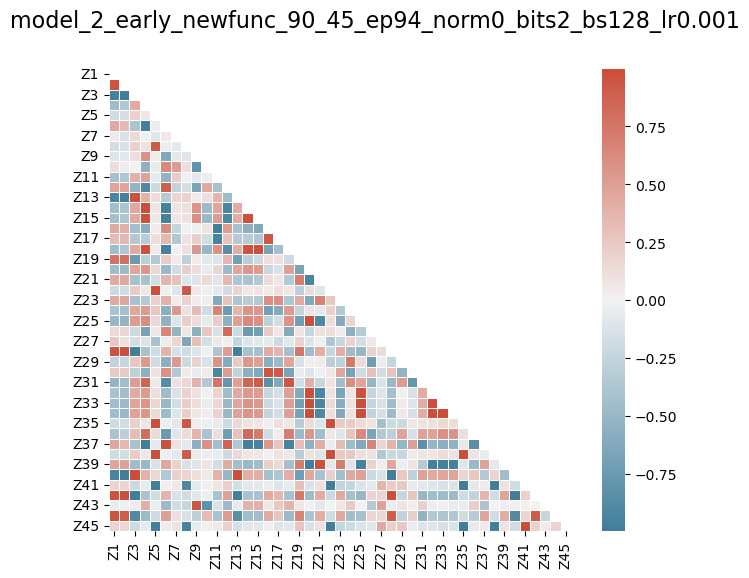

In [44]:

xbatch, tmask, _ =  next(iter(train_loader))
with torch.inference_mode():
    z_mu, z_logvar = model.get_latent_variables(xbatch,detach=True)
# make a dataframe with columns the dmensions of the latent space
dim_cols = [f"Ζ{z}" for z in range(1,z_mu.shape[1]+1)]
dim_df = pd.DataFrame(z_mu.numpy(), columns=dim_cols)
# dim_df

# make a correlation matrix of the latent varables
plt.figure(figsize=(8,6))

# # color codes by matplotlib RGB to decimals
# dark_blue = (39/255, 93/255, 181/255)
# blue = (166/255, 216/255, 235/255) 
# red = (220/255, 39/255, 38/255)  
# gray = (0.85, 0.85, 0.85) 


# # color sections 
# colors = [
#     (0, gray),  
#     (0.325, gray),  # Light Blue
#     (0.325, gray),  # Gray transition
#     (0.75, gray),   # Gray transition
#     (0.75, red),    # Light Red
#     (1.00, (100/255, 39/255, 38/255))  
# ]

cmap = sns.diverging_palette(230, 17, as_cmap=True)
# custom_map = mcolors.LinearSegmentedColormap.from_list('custom_map', colors)

triag_mask = np.triu(np.ones_like(dim_cols,dtype=bool))

sns.heatmap(data=dim_df.corr(), mask=triag_mask, annot=False, cmap = cmap,
            square=True, linewidths=.5)
plt.suptitle(f"{model_id}",fontsize=16)
plt.savefig(path + "\\latent_var_corplot.png", dpi=600, bbox_inches="tight")
plt.show()

In [45]:
print(type(test_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


### UMAP of the Latent Variables 
- We will used the scaled - non-shuflled matrix because we are interested in retaining the original row order.
- We will perform umap to the latent posterior
- With predefined clusters, we will visualize the effect of the latent variables to their formation.


In [46]:
full_data = DataLoader(cd.ProteinDataset(npscbc_scaled), batch_size=128, shuffle=False)

Protein Dataset is passed to memory
No Protein Symbols were identified


In [47]:
xrec_list = []
latent_list = []
mask_list = []
model.eval()
with torch.inference_mode():
    for batch, mask, idx in full_data:
        batch, mask = batch.to(device), mask.to(device)
        # print(batch.shape, mask.shape)

        # get x_mu
        x_mu, _, _, _ = model(batch) # forward step 
        # print(x_mu.shape)
        xrec_list.append(x_mu.detach().cpu())

        # get z_mu
        z_mu, _ = model.get_latent_variables(batch, detach=True)
        # print(z_mu.shape)

        latent_list.append(z_mu.cpu())
        # print(len(latent_list))
        mask_list.append(mask.detach().cpu())
# concatenate list of tensors and convert them to numpy matrices
latent_list = torch.cat(latent_list,dim=0)
xrec_list = torch.cat(xrec_list,dim=0)
mask_list = torch.cat(mask_list,dim=0)

latent_matrix = latent_list.numpy()
xrec_matrix = xrec_list.numpy()
mask_matrix = mask_list.numpy()



In [57]:
model_id

'model_2_early_newfunc_90_45_ep94_norm0_bits2_bs128_lr0.001'

In [59]:
# save the latent dimensions
latent_df = pd.DataFrame(latent_matrix, columns=dim_cols, index=scbc.index)
latent_df.to_csv(os.getcwd() + "\\data\\processed\\" +model_id + ".csv", index=True)

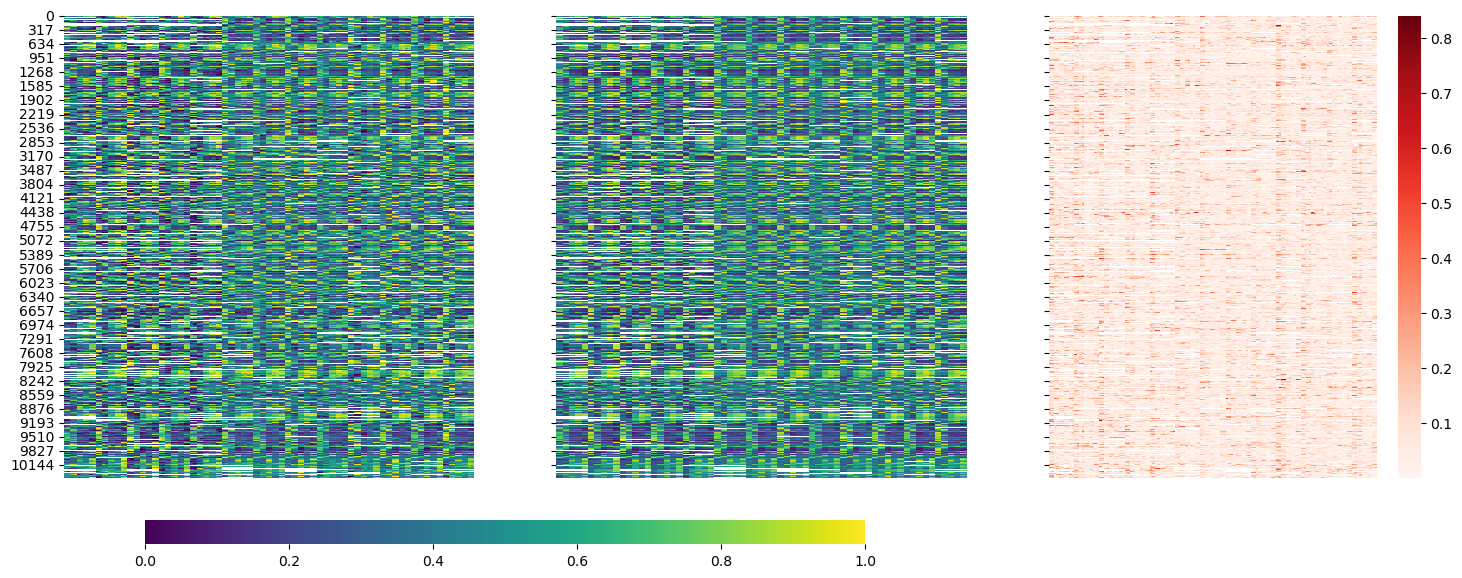

In [48]:
fig, axes = plt.subplots(1,3,figsize=(18,6),sharey=True)

ax1 = sns.heatmap(npscbc_scaled, cmap="viridis",vmin=0,vmax=1,
                  mask=mask_matrix,xticklabels=False, ax=axes[0],
                  cbar = False)

ax2 = sns.heatmap(xrec_matrix, cmap="viridis",vmin=0,vmax=1,
                  mask=mask_matrix,xticklabels=False,ax=axes[1],
                  cbar_ax=fig.add_axes([.17, 0, .4, .04]),
                  cbar_kws={"orientation": "horizontal"})

ax3 = sns.heatmap(np.abs(npscbc_scaled-xrec_matrix), cmap="Reds",
                  mask=mask_matrix,xticklabels=False, ax=axes[2])

In [49]:
marker_df = pd.read_csv(os.getcwd()+"\\data\\raw\\markerproteins.csv")
marker_df["Colour"].unique()
marker_df.groupby("Compartments")["Colour"].unique()

Compartments
C1       [lightblue]
C2      [aquamarine]
C3            [cyan]
C4    [deepskyblue2]
C5      [turquoise3]
M1      [burlywood4]
M2            [tan4]
N1          [grey90]
N2          [grey70]
N3          [grey50]
N4          [grey30]
S1            [gold]
S2          [orange]
S3          [salmon]
S4         [tomato2]
Name: Colour, dtype: object

In [50]:
# color headache
# Define compartments with their corresponding R colors
compartment_colors = {
    "C1": "lightblue",
    "C2": "aquamarine",
    "C3": "cyan",
    "C4": "deepskyblue2",
    "C5": "turquoise3",
    "M1": "burlywood4",
    "M2": "tan4",
    "N1": "grey90",
    "N2": "grey70",
    "N3": "grey50",
    "N4": "grey30",
    "S1": "gold",
    "S2": "orange",
    "S3": "salmon",
    "S4": "tomato2"
}

# Matplotlib color codes (converted from R colors)
color_mapping = {
    'tomato2': '#EE5C42',
    'deepskyblue2': '#03A9F4',
    'cyan': '#00FFFF',
    'turquoise3': '#00C5CD',
    'grey50': '#7F7F7F',
    'gold': '#FFD700',
    'tan4': '#8B5A2B',
    'salmon': '#FA8072',
    'orange': '#FFA500',
    'aquamarine': '#7FFFD4',
    'lightblue': '#ADD8E6',
    'burlywood4': '#8B7355',
    'grey70': '#B3B3B3',
    'grey90': '#E5E5E5',
    'grey30': '#4D4D4D'
}

# Exchange Rstudio colors with matplotlib colors
compartment_color_map = {comp: color_mapping[color] for comp, color in compartment_colors.items()}

# Each cluster is linked to a color code 
print(compartment_color_map)

marker_df["color2"] = marker_df["Compartments"].map(compartment_color_map)
marker_df.head()

{'C1': '#ADD8E6', 'C2': '#7FFFD4', 'C3': '#00FFFF', 'C4': '#03A9F4', 'C5': '#00C5CD', 'M1': '#8B7355', 'M2': '#8B5A2B', 'N1': '#E5E5E5', 'N2': '#B3B3B3', 'N3': '#7F7F7F', 'N4': '#4D4D4D', 'S1': '#FFD700', 'S2': '#FFA500', 'S3': '#FA8072', 'S4': '#EE5C42'}


,Unnamed: 0,Proteins,Compartments,Cyto,Nsol,NucI,Horg,Lorg,Colour,color2
0,AAAS,AAAS,S4,-1.003352,-1.154895,0.930337,0.485543,0.161833,tomato2,#EE5C42
1,AACS,AACS,C4,2.171657,0.132460,-1.039463,-1.132656,-1.321762,deepskyblue2,#03A9F4
2,AAK1,AAK1,C3,1.855645,0.100153,-0.660551,-0.369851,-0.674196,cyan,#00FFFF
3,AARS,AARS,C4,2.101283,0.058558,-1.043925,-1.084520,-1.218098,deepskyblue2,#03A9F4
4,AASDHPPT,AASDHPPT,C5,1.706590,0.515071,-0.719659,-0.652672,-1.005984,turquoise3,#00C5CD


In [51]:
# reconstruct the dataframes rawscbc and latentscbc

rawscbc = pd.DataFrame(npscbc_scaled, index=scbc.index)
latentscbc = pd.DataFrame(latent_matrix, index=scbc.index)

rawscbc_markers = rawscbc.loc[rawscbc.index.isin(marker_df["Proteins"])]
latentscbc_markers = latentscbc.loc[latentscbc.index.isin(marker_df["Proteins"])]
# latentscbc_markers.index == marker_df.index
latentscbc_markers.head()

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
AAAS,-0.109972,-0.101050,0.147236,1.076270,0.754859,-1.025781,0.000575,0.580085,0.763123,-0.667679,...,0.804496,-1.002815,0.741479,-0.431930,0.061187,-0.769285,-0.058998,0.574761,-0.131480,-0.710263
AACS,0.746473,0.853608,-0.865268,-0.765105,0.146654,0.556911,-0.564570,0.037176,0.445099,-0.565621,...,-0.657380,0.734616,0.088546,0.523952,-0.826181,-0.116363,0.817711,0.494739,0.392524,-0.180676
AAK1,0.590886,0.709586,-0.743932,-0.671171,0.246064,0.594413,-0.629145,0.124909,-0.045585,-0.236802,...,-0.221487,0.586902,0.256378,0.288890,-0.800233,-0.203938,0.776114,0.111109,0.488372,-0.206334
AARS,0.756880,0.841134,-0.843079,-0.752317,0.199879,0.593728,-0.494031,0.174062,0.288135,-0.366783,...,-0.649346,0.733965,0.196474,0.569294,-0.821163,-0.214529,0.820728,0.340135,0.482415,-0.290114
AASDHPPT,0.999415,1.036090,-1.109976,-0.853203,0.084106,0.612621,-0.401771,-0.187356,0.129791,-0.347806,...,-0.599300,0.838486,-0.034799,0.224879,-1.051950,0.029676,1.045305,0.206305,0.622276,0.036770


In [52]:
# aplly umap and plot the 3D or 2D features cluster-wise 
data = latentscbc_markers
n_neighbors = 25
min_dist = 0.1
n_components = 3
metric = "euclidean"
# Create a UMAP object with custom parameters
umap_model = umap.UMAP(n_neighbors=n_neighbors,
                           min_dist=min_dist,
                           n_components=n_components,
                           metric=metric,
                           random_state=6) 
    
# Fit the UMAP model and transform the data
umap_latent = umap_model.fit_transform(data)

c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [53]:
# recreate the dataframe and merge the umap coordinates with the marker df to plot in 3D
# marker_df["Proteins"]
# umap_latent["Proteins"] = latentscbc_markers.index
umap_lat_df = pd.DataFrame(umap_latent, index= latentscbc_markers.index)
umap_lat_df["Proteins"] = latentscbc_markers.index
umapz_df = pd.merge(umap_lat_df,marker_df, on="Proteins", how="left")
umapz_df.rename(columns={0:"dim1",1:"dim2",2:"dim3"}, inplace=True)
umapz_df.head()

,dim1,dim2,dim3,Proteins,Unnamed: 0,Compartments,Cyto,Nsol,NucI,Horg,Lorg,Colour,color2
0,2.961296,10.098736,3.344751,AAAS,AAAS,S4,-1.003352,-1.154895,0.930337,0.485543,0.161833,tomato2,#EE5C42
1,17.709587,2.772164,8.007292,AACS,AACS,C4,2.171657,0.132460,-1.039463,-1.132656,-1.321762,deepskyblue2,#03A9F4
2,17.016134,1.765580,7.026672,AAK1,AAK1,C3,1.855645,0.100153,-0.660551,-0.369851,-0.674196,cyan,#00FFFF
3,17.624252,2.413244,7.092607,AARS,AARS,C4,2.101283,0.058558,-1.043925,-1.084520,-1.218098,deepskyblue2,#03A9F4
4,17.024071,2.704940,7.546184,AASDHPPT,AASDHPPT,C5,1.706590,0.515071,-0.719659,-0.652672,-1.005984,turquoise3,#00C5CD


In [54]:
model_id

'model_2_early_newfunc_90_45_ep94_norm0_bits2_bs128_lr0.001'

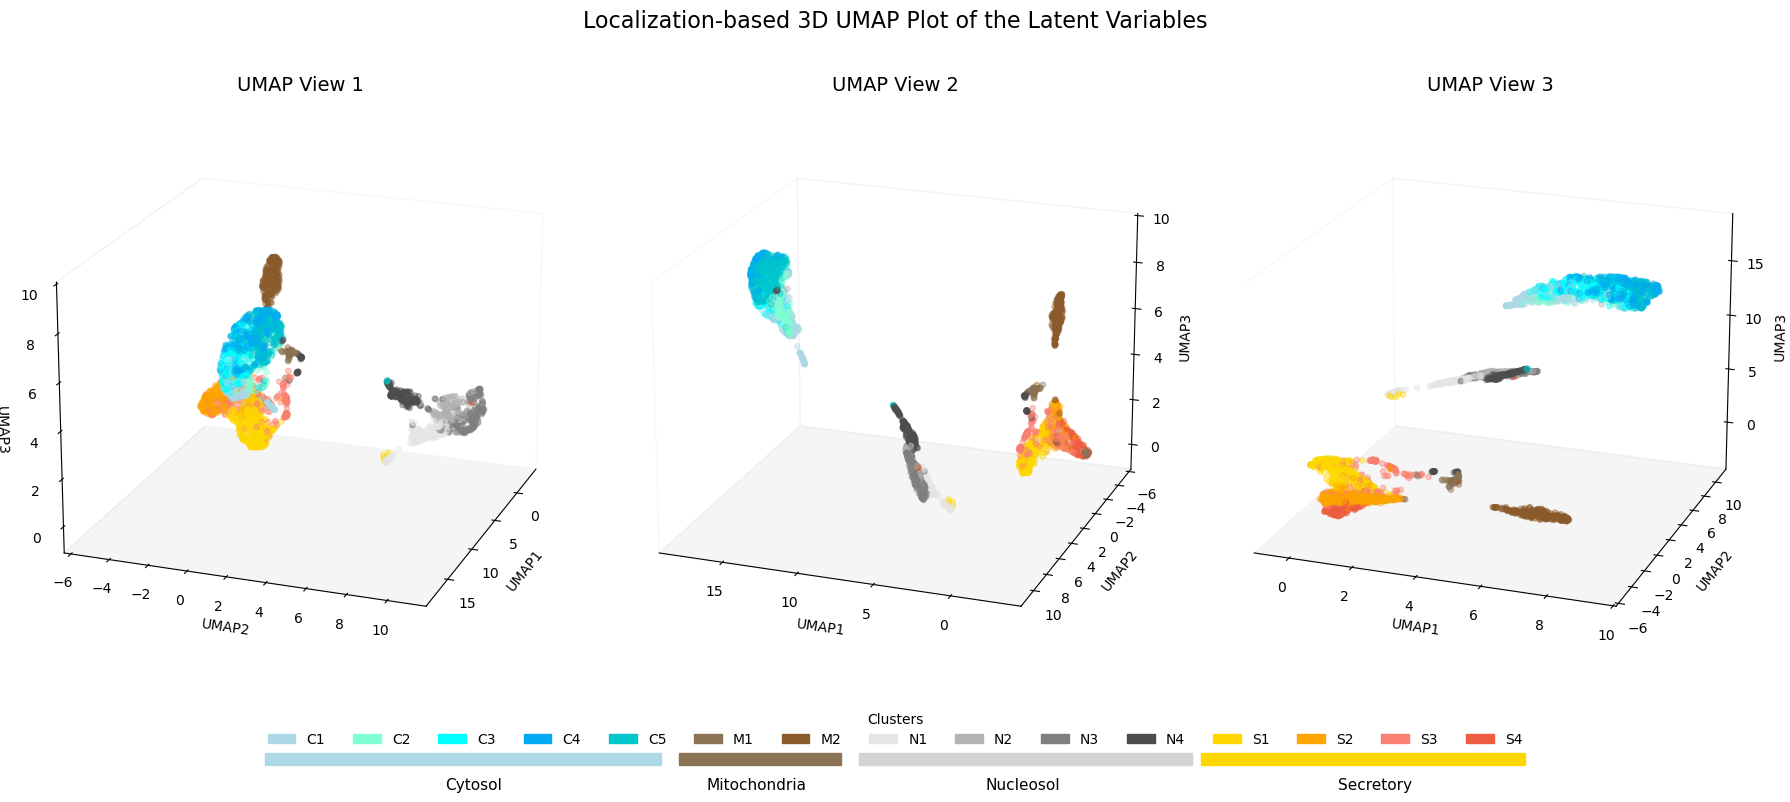

In [55]:
uf.plot_umap3d(umap_df=umapz_df,
            savepath = model_path)

In [56]:
uf.plot_umap3d_plotly(umap_df=umapz_df, savepath = model_path + "//umap3d_latent.html")

Figure saved as HTML to: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\model_2_early_newfunc_90_45//umap3d_latent.html
